# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [3]:
# Class for converting timestamps between recording systems using sync pulses with 
# random inter-pulse intervals. 
# https://pycontrol.readthedocs.io/en/latest/user-guide/synchronisation
# Dependencies:  Python 3, Numpy, Matplotlib, Scikit-learn.
# (c) Thomas Akam 2018. Released under the GPL-3 open source licence.

import numpy as np
import pylab as plt
from sklearn.mixture import GaussianMixture

class RsyncError(Exception):
    pass

class Rsync_aligner():

    def __init__(self, pulse_times_A, pulse_times_B, units_A=1, units_B=1, 
                 chunk_size=5, plot=False, raise_exception=True):
        '''Class for converting timestamps between two recording systems
        (e.g  pyControl and an ephys) using sync pulses with random inter-pulse
        intervals recorded on both systems.  Typically these sync pulses are generated
        by pyControl using the Rsync hardware object and sent to other systems. To use the
        Rsync_aligner,instantiate it by providing the sync pulse times recorded by each
        system. Timestamps from either system can then be converted into the reference frame
        of the other using the A_to_B and B_to_A methods.  If the hardware systems use 
        different units to measure time this must be specified using the units arguments
        when the aligner is instantiated. When the aligner is instantiated it works out 
        which pulses in each reference frame correspond to each other by by aligning 
        short chunks of pulse sequence A with B by minimising the mean squared error 
        between inter-pulse intervals.
        Arguments:
        pulse_times_A: The times when sync pulses occured recorded by hardware system A.
        pulse_times_B: The times when sync pulses occured recorded by hardware system B.
        units_A: The time units used by system A expressed in milliseconds.  E.g. if 
                 system A uses units of seconds the *units_A* argument is 1000.  
        units_B: The time units used by system B expressed in milliseconds.
        plot: Whether to plot information about the alignment.
        raise_exception: If *True* an RsyncError exception is raised if no match is found
                         between the sync pulse sequences.
        '''

        # Convert all units to ms.
        pulse_times_A = pulse_times_A*units_A
        pulse_times_B = pulse_times_B*units_B
        # Evalute inter pulse intervals
        intervals_A = np.diff(pulse_times_A) # Inter-pulse intervals for sequence A
        intervals_B = np.diff(pulse_times_B) # Inter-pulse intervals for sequence B
        intervals_B2 = intervals_B**2
        # Find alignments of chunks which minimise sum of squared errors.
        chunk_starts_A = np.arange(0, len(pulse_times_A)-chunk_size, chunk_size) # Start indices of each chunk of sequence A.
        chunk_starts_B = np.zeros(chunk_starts_A.shape, int)                     # Start indicies of corresponding chunks in B.
        chunk_min_mse = np.zeros(chunk_starts_A.shape) # Mean squared error for each chunks best alignment.
        chunk_2nd_mse = np.zeros(chunk_starts_A.shape) # Mean sqared error for each chunks second best (i.e non matching) alignment.
        ones_chunk = np.ones(chunk_size)
        for i, csA in enumerate(chunk_starts_A):
            chunk_A = intervals_A[csA:csA+chunk_size]
            mse = (  np.correlate(intervals_B2, ones_chunk, mode='valid') + np.sum(chunk_A**2) -
                   2*np.correlate(intervals_B , chunk_A   , mode='valid')) / chunk_size
            chunk_starts_B[i]  = np.argmin(mse)
            sorted_chunk_min_mse = np.sort(mse)
            chunk_min_mse[i] = sorted_chunk_min_mse[0]
            chunk_2nd_mse[i] = sorted_chunk_min_mse[1]
        # Assign chunks to matched and non-matched groups by fitting 2 component
        # Gaussian mixture model to log mse distribition of best + second best 
        # alignments.
        chunk_mse = np.hstack([chunk_min_mse,chunk_2nd_mse]) 
        chunk_mse[chunk_mse == 0] = np.min(chunk_mse[chunk_mse != 0]) # Replace zeros with smallest non zero value.
        log_mse = np.log(chunk_mse)
        log_mse = log_mse[np.isfinite(log_mse)].reshape(-1,1)
        gmm = GaussianMixture(n_components=2, covariance_type='spherical')
        gmm.fit(log_mse)
        valid_matches = gmm.predict(log_mse) == np.argmin(gmm.means_) # True for chunks which are valid matches.
        # Make arrays of corresponding times.
        cor_times_A = np.full(pulse_times_B.shape, np.nan) # A pulse times corresponding to each B pulse.
        cor_times_B = np.full(pulse_times_A.shape, np.nan) # B pulse times corresponding to each A pulse.
        for csA, csB, valid in zip(chunk_starts_A, chunk_starts_B, valid_matches):
            if valid:
                cor_times_A[csB:csB+chunk_size] = pulse_times_A[csA:csA+chunk_size]
                cor_times_B[csA:csA+chunk_size] = pulse_times_B[csB:csB+chunk_size]
        # Store pulse times, their correspondences and units.
        self.pulse_times_A = pulse_times_A
        self.pulse_times_B = pulse_times_B
        self.cor_times_A = cor_times_A
        self.cor_times_B = cor_times_B
        self.units_A = units_A
        self.units_B = units_B
        # Check quality of alignment.
        separation_OK = (np.abs(gmm.means_[0]-gmm.means_[1])[0] >  # Different in GMM means > 3 x sum of standard deviations.
                         3*np.sum(np.sqrt(gmm.covariances_)))
        order_OK = ((np.nanmin(np.diff(cor_times_A)) > 0) and
                    (np.nanmin(np.diff(cor_times_A)) > 0)) # Corresponding times are monotonically increacing.
        if not (separation_OK and order_OK):
            if raise_exception:
                raise RsyncError('No match found between inter-pulse interval sequences.')
            else:
                print('Rsync warning: No match found between inter-pulse interval sequences.')
        # Plotting
        if plot:
            plt.figure(plot if type(plot)==int else 1, figsize=[7,9]).clf()
            plt.subplot2grid((3,3),(0,0),rowspan=1,colspan=2)
            plt.hist(log_mse[ valid_matches], 20, color='b', label='Match')
            plt.hist(log_mse[~valid_matches], 20, color='r', label='Non-match')
            plt.legend(loc='upper center')
            plt.xlabel('Log mean squared error')
            plt.ylabel('# chunks')
            plt.subplot2grid((3,3),(0,2),rowspan=1,colspan=1)
            timing_errors = np.diff(cor_times_A) - np.diff(pulse_times_B)
            plt.hist(timing_errors[~np.isnan(timing_errors)],100)
            plt.yscale('log', nonposy='clip')
            plt.xlabel('Inter-pulse interval\ndiscrepancy (ms)')
            plt.ylabel('# pulses')
            plt.subplot2grid((3,1),(1,0),rowspan=2,colspan=1)
            plt.plot(pulse_times_A/units_A, cor_times_B/units_B , '.', markersize=2)  
            plt.xlim(pulse_times_A[0]/units_A,pulse_times_A[-1]/units_A)
            plt.xlabel('pulse times A')
            plt.ylabel('pulse times B')
            plt.tight_layout()

    def A_to_B(self, times_A):
        '''Convert times in A reference frame to B reference frame.'''
        return np.interp(times_A*self.units_A, self.pulse_times_A, self.cor_times_B,
                         left=np.nan, right=np.nan)/self.units_B

    def B_to_A(self, times_B):
        '''Convert times in B reference frame to A reference frame.'''
        return np.interp(times_B*self.units_B, self.pulse_times_B, self.cor_times_A,
                         left=np.nan, right=np.nan)/self.units_A

# --------------------------------------------------------------------------

def simulate_pulses(n_pulse=1000,interval=[100,1900], noise_SD=3, missing_pulses=False):
    ''' Simulate a pair of pulse trains timestamps with drift between their timings.'''
    pulse_times_A = np.cumsum(np.random.randint(*interval, size=n_pulse)).astype(float)
    pulse_times_B = pulse_times_A + np.cumsum(np.random.normal(scale=noise_SD, size=n_pulse))
    if missing_pulses:

        pulse_times_A = np.hstack([pulse_times_A[int(n_pulse*0.05):int(n_pulse*0.21)],pulse_times_A[int(n_pulse*0.33):]])
        pulse_times_B = np.hstack([pulse_times_B[:int(n_pulse*0.74)],pulse_times_B[int(n_pulse*0.85):int(n_pulse*0.95)]])
    return pulse_times_A, pulse_times_B


#  Helper functions

In [4]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [5]:
def get_transitions_state(graph_type):
    
    transitions = [[i,i+1] for i in range(8)]
    transitions.extend([[i,i-1] for i in range(1,9)])
    if graph_type=='loop':
        transitions.extend([[0,8],[8,0]])
        
    all_transitions = []
    for kk, pk in enumerate(transitions):
        all_transitions.append(str(pk[0])+'_'+str(pk[1]))
    return all_transitions

In [1295]:
def plot_activity_on_graph(sequence,graph_type,order='poke',spks=None,node_size=512,mx=None,mn=None):
    """ This plots all transitions based on the final sequence
    
    Argument:
    ==============================
    
    order:          str (poke|state)
                    this specifies whether spks in ordered
                    in terms of pokes in physical space or in terms the
                    abstract states in the task and will change how it is plotted accordingly
    
    """
    
    if order=='poke':
        poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])
    elif order=='state':
        x_ = np.linspace(0,2*np.pi,num=9).tolist()
        tmp = np.linspace(0,2*np.pi,num=9)#[x_[i] for i in sequence]
        poke_pos = np.vstack([np.sin(tmp),np.cos(tmp)]).T
    else:
        raise Exception("order argument must be set to either 'poke' or 'state'")


    if spks is None: spks='.3'
        
    G = nx.DiGraph()

    if len(spks)!='.3':
        cmap_ = 'RdBu_r'
        if mx is None: mx = np.max(spks)
            
        if mn is None: mn = 0
        cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=mn,vmax=mx,clip=True),cmap=cmap_)

        for i in range(9):
            c = spks[i]
            #pos = poke_pos
            G.add_node(i,pos=poke_pos[i],color=cmap.to_rgba(c))
        
    seq_inv = [sequence.index(i) for i in range(9)]
    if order=='poke':
        all_transitions = get_all_transition(sequence,graph_type)
    elif order=='state':
        all_transitions = get_transitions_state(graph_type)
    #print(all_transitions)
    for e in all_transitions:
        #print(all_transitions)
        G.add_edge(int(e[0]),int(e[-1]))

    node_colors = nx.get_node_attributes(G,'color')
    if order=='poke':
        #G.edges
        nx.draw(G,
                pos=poke_pos,edge_color=".3",
                node_color=np.array(list(node_colors.values())),
                node_size=node_size,
                connectionstyle="arc3,rad=-0.1",
                width=2,
                with_labels=False,
                #node_labels=sequence
        )
        label_seq = dict([(i,seq_inv[i]) for i in range(9)])
        nx.draw_networkx_labels(G,poke_pos, label_seq)

    else:
        nx.draw_circular(G,
                         edge_color='.3',
                         node_color=np.array(list(node_colors.values())),
                         node_size=node_size,
                        connectionstyle="arc3,rad=-0.1",
                        width=2,
                        with_labels=False)
        label_seq = dict([(seq_inv[i],i) for i in range(9)])
        pos_ = nx.drawing.layout.circular_layout(G)
        nx.draw_networkx_labels(G,pos_, label_seq)


In [7]:
events

NameError: name 'events' is not defined

In [1132]:
def build_poke_df(lines,events,sync_thing=0):
    
    df = pd.DataFrame(columns=['target','port','state','task_nr','direction','in_timeout','n_timeouts','probe','correct',
                               'previous_port','previous_state','reward','block_nr','task_repeat_nr','port_repeat','next_correct',
                               'frac_corr','RT','time','current_sequence','graph_type' #behavioural variables
                              ]) 
    
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    current_block_number = -1
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            #if poke_dict is not None:
            #    all_poke_dict.append(cp.deepcopy(poke_dict))
            #poke_dict = {}
            current_block_number += 1
            current_task = re.findall(r'task_number([0-9])',l)[0]
            current_sequence = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            current_graph_type = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]
            #poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            #poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            #poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            if len(df)>1:
                previous_port = df.iloc[-1]['port']
                if not df.iloc[-1]['correct']:
                    current_is_repeat = True
                    df.loc[len(df)-2,'next_correct'] = False

                else:
                    current_is_repeat = False
                    df.loc[len(df)-2,'next_correct'] = True

            else:
                previous_port = None
                current_is_repeat = False
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            
                
                
            
            #print(current_sequence)
            if len(rew_hist)>2:
                poke_dct = {
                          'target': int(target),
                          'port': int(poke),
                          'state': current_sequence.index(int(poke)),
                          'task_nr': current_task,
                          'direction': direction,
                          'in_timeout': False,
                          'n_timeouts': np.nan,
                          'probe': probe,
                          'correct': poke==target,
                          'reward': n_rew==rew_hist[-2],
                          'block_nr':current_block_number,
                          'task_repeat_nr': int(np.floor(current_block_number/2)),
                          'frac_corr': None,
                          'RT':None,
                          'time':t_,
                          'current_sequence': current_sequence,
                          'graph_type': current_graph_type,
                          'port_repeat':current_is_repeat,
                                  }
                df = df.append(poke_dct,ignore_index=True)

       
    return df
    

In [1133]:
def get_in_task_pokes(lines,events,sync_thing=0):
    """ This builds a list of dictionaries about what happened in the task.
        Each dictionary contains the times of pokes in each of the ports 
        and some metadata about the currenct task (e.g. the structure of
        the current task [line or loop] and the sequence of ports). The mouse
        does the task in blocks that alternate between the two structures it has
        learned. Each block has its own dictionary.
        """
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            if poke_dict is not None:
                all_poke_dict.append(cp.deepcopy(poke_dict))
            poke_dict = {}
            poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            #print(poke,target)
            if len(target_hist)>3:
                if (poke==target and 
                    #target!=target_hist[-2] and 
                    n_rew_in_seq>5 and
                    direction==1 and
                    n_rew==rew_hist[-2] and
                    probe==False):
                    #print(poke)
                    if poke in poke_dict.keys():
                        poke_dict[poke].append(t_)
                    else:
                        poke_dict[poke] = [t_]
                    #poke_dict[poke]
    all_poke_dict.append(poke_dict)
    return all_poke_dict

In [1134]:
l_ =  'P 72521 REWS:7, REW_IN_SEQ:7, POKED: 7, PROBE: False , TARGET: 0,SEQ_IX: 3, DIR: -1\n'


In [1135]:
def plot_cell(ix,all_resps_g1,all_resps_g2,all_poke_dict,norm=False,norm_pct=90):
    plt.figure(figsize=(12,4))
    n_plot = 1
    ctr = 0
    resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
    resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]

    if norm:
        mx = np.percentile(np.concatenate([all_resps_g1[ix],all_resps_g2[ix]]),norm_pct)
    else:
        mx = None
    plt.subplot(n_plot,4,4*ctr+1)
    spks = all_resps_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',mx=mx)
    plt.subplot(n_plot,4,4*ctr+2)
    spks = all_resps1_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='poke',mx=mx)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='state',mx=mx)
    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='state',mx=mx)
    
    ctr +=1

In [1136]:
re.findall('PROBE: ([True?|False])','P 3377 REWS:0, REW_IN_SEQ:0, POKED: 2, PROBE: True , TARGET: 1,SEQ_IX: 1, DIR: 1')[0]=='T'


True

In [1137]:
int('-1')

-1

# Actual code

In [1299]:
#Load behavioural data
root_path = '/Users/yves/Downloads/example_files4/'

all_fs = os.listdir(root_path)

task_path = os.path.join(root_path,[i for i in all_fs if '.txt' in i][0])
lines = open(task_path,'r').readlines()


#load neural data timestamps

sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [1300]:
#Extract the timestamps of the sync-pulses between the neural data and the behavioural data
events = eval(lines[9][2:])
bnc_ev = events['BNC_input']
sync_messages_task =[int(re.findall(r' ([0-9]*)',l)[0]) for l in lines if str(bnc_ev)+'\n' in l and l[0]=='D']
poke_event_ids = [events['poke_'+str(i)] for i in range(1,10)]
print(poke_event_ids)

[7, 9, 11, 13, 15, 17, 19, 21, 23]


In [1301]:
#align neural and behavioural timestamps
aligner = Rsync_aligner(sync_messages_spk,np.array(sync_messages_task)[1:],units_A=1/30.,units_B=1)

In [1302]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [1303]:
conds = ((df['port']==port_nr) &
                   (df['target']==port_nr) & 
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr))

In [1304]:
df = build_poke_df(lines,events)


0       False
1       False
2       False
3        True
4       False
        ...  
1110    False
1111    False
1112     True
1113      NaN
1114      NaN
Name: next_correct, Length: 1115, dtype: object

In [1306]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   (df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr))
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            
        
        if port_nr==8:
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]




0 14 0
0 19 1
0 23 2
0 6 3
0 21 4
0 20 5
0 20 6
0 18 7
0 6 8


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


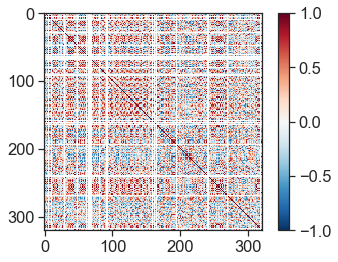

In [1307]:
plt.imshow(np.corrcoef(all_resps_g1),interpolation='None',cmap='RdBu_r',vmin=-1,vmax=1)
plt.colorbar()

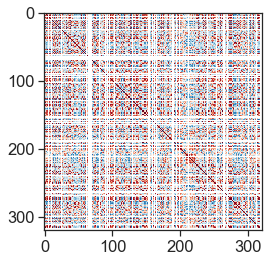

In [1308]:
plt.imshow(np.corrcoef(all_resps_g2),interpolation='None',cmap='RdBu_r',vmin=-1,vmax=1)


In [1309]:
def get_all_resps(aligner,poke_dict,single_units,spkT,spkC,window0=3000,window1=6000):
    """ This code gets the average response of all cells to pokes in a single task block
    """
    all_resps = []
    all_resps1 = []
    all_resps2 = []
    scaleF = (window0+window1)/30000.
    
    for unit in single_units:#[n_:n_+1]:  #loop over all cells
        
        spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell
        
        resps = [[] for _ in range(9)]
        resps1 = [[] for _ in range(9)]
        resps2 = [[] for _ in range(9)]
        for key,vals in poke_dict.items():  #loop over pokes
            if re.findall('[0-9]',key): #ignore dictionary items that are metadata like the sequence and graph time
                aligned_T = aligner.B_to_A(vals) #align pokes into spike times

                #get the spikes that are in bounds for position encoding
                pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
                
                used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
                key = int(key)
                half_npks = int(len(used_pks)/2)
                #print(key,half_npks)
                for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                    
                    #this is a block of code to split the data in half, useful for looking at stability when you
                    #only have one task block
                    nSpikes = len(np.where(np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1)))[0])
                    firing_rate = scaleF*float(nSpikes)
                    
                    if pk_ix<=half_npks:
                        resps2[key].append(firing_rate)
                        
                    else:
                        resps1[key].append(firing_rate)

                    resps[key].append(firing_rate)

                    
                    
        all_resps.append(resps.copy())
        all_resps1.append(resps1.copy())
        all_resps2.append(resps2.copy())
        
    return all_resps, [all_resps1,all_resps2]

In [1310]:
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)

In [1311]:
poke_dict_t1['graph_type']

'loop'

In [1312]:
poke_dict_t1['graph_type']

'loop'

In [1313]:
def get_mean_resps(all_resps_single_trial):
    mus = []
    vs = []
    mu_g1 = []
    var_g1 = []
    for neuron in all_resps_single_trial:
        tmp_mu = []
        tmp_var = []
        for poke in neuron:
            tmp_mu.append(np.mean(poke))
            tmp_var.append(np.var(poke))
        mu_g1.append(tmp_mu)
        var_g1.append(tmp_var)

    return np.array(mu_g1),np.array(var_g1)

In [1314]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [1315]:
all_resps1_g1.shape

(228, 9)

0.8056036774635378
2.4010969040300436


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


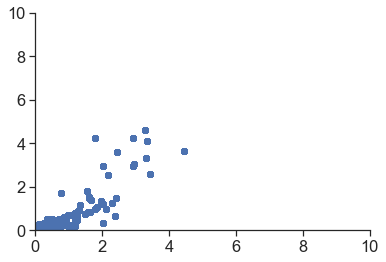

In [1316]:
plt.scatter(mus,vs)
print(np.corrcoef(mus,vs)[0,1])
print(np.nanmean(np.array(mus)/np.array(vs)))
#plt.yscale('symlog')
#plt.xscale('symlog')
plt.xlim(0,10); plt.ylim(0,10)
seaborn.despine()

In [1317]:
from sklearn.decomposition import pca

In [1318]:
ft = pca.PCA(n_components=4)
out = ft.fit(np.array(all_resps_g1))

In [1319]:
reconstuction_across = []
back_forth = out.inverse_transform(out.transform(all_resps_g2))
for i,cell_approx in enumerate(back_forth):
    cc_ = np.corrcoef(cell_approx,all_resps1_g2[i])[0,1]
    reconstuction_across.append(cc_)
reconstuction_across = np.array(reconstuction_across)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


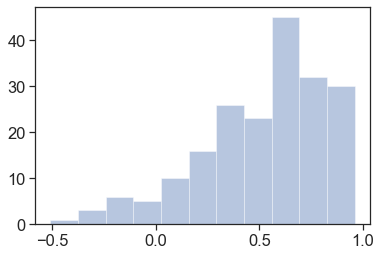

In [1320]:
seaborn.distplot(reconstuction_across[np.isfinite(reconstuction_across)],kde=0)

In [ ]:
spatial_transition_matrix = [0,1,1]

In [1321]:
#
ccs_within1 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within1.append(np.corrcoef(r1,r2)[0,1])
    
ccs_within1 = np.array(ccs_within1)
print(np.nanmean(ccs_within1))

0.3129449605815273


In [1322]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
    ccs_within2.append(np.corrcoef(r1,r2)[0,1])
ccs_within2 = np.array(ccs_within2)

print(np.nanmean(ccs_within2))

0.3671984587250382


In [1323]:
ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)

In [1324]:
#
ccs_across = []
for r1,r2 in zip(all_resps_g1,all_resps_g2):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.4171858696853139


Text(0, 0.5, 'within_task2 stability')

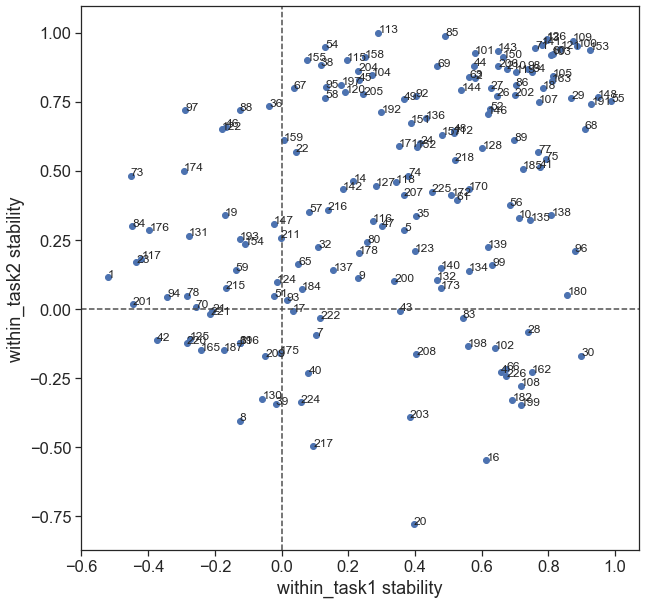

In [1325]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_within1,ccs_within2)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_within1[i], ccs_within2[i]),fontsize=12)

plt.xlabel('within_task1 stability')
plt.ylabel('within_task2 stability')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


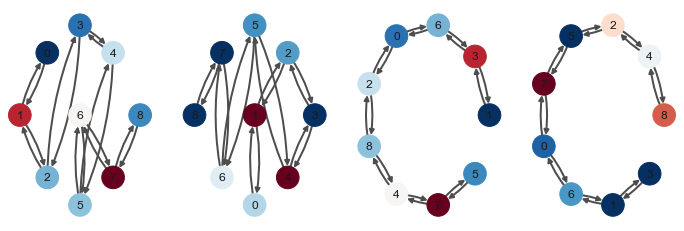

In [1326]:
plot_cell(211,all_resps_g1,all_resps_g2,all_poke_dict,norm=True,norm_pct=90)

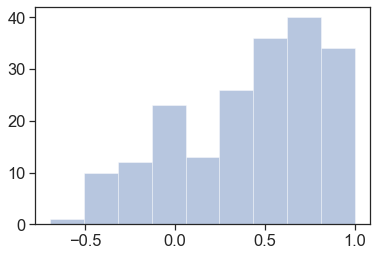

In [1327]:
seaborn.distplot(np.array(ccs_across)[np.isfinite(ccs_across)],kde=0)

Text(0, 0.5, 'within_task_stability')

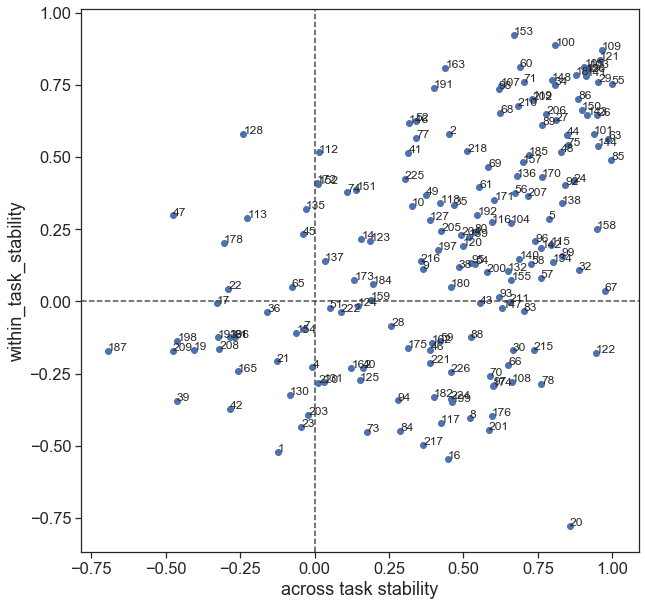

In [1328]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_across,ccs_within)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_across[i], ccs_within[i]),fontsize=12)

plt.xlabel('across task stability')
plt.ylabel('within_task_stability')

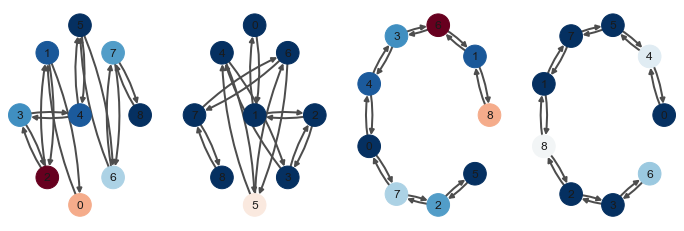

In [1198]:
plot_cell(228,all_resps_g1,all_resps_g2,all_poke_dict,norm=True,norm_pct=99)

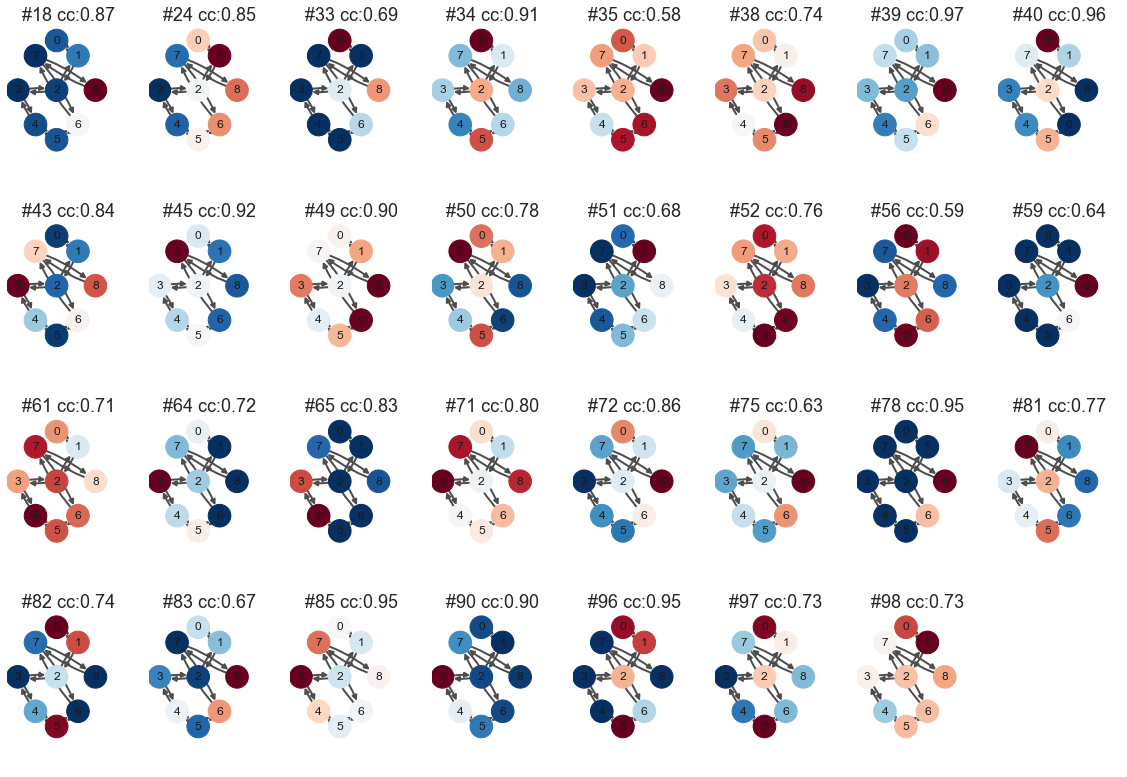

In [1102]:
plt.figure(figsize=(16,22))
ctr = 0
for ctr_,spks in enumerate(all_resps1_g2[:100]):
    if ccs_within[ctr_]>0.5:
        plt.subplot(8,8,ctr+1)
        plt.title('#'+str(ctr_) + ' cc:' + '{:.2f}'.format(ccs_within[ctr_]))
        #nx.draw_circular(G,node_color=spks,node_size=512)
        plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',node_size=512)
        axis = plt.gca()
        # maybe smaller factors work as well, but 1.1 works fine for this minimal example
        axis.set_xlim([1.3*x for x in axis.get_xlim()])
        axis.set_ylim([1.3*y for y in axis.get_ylim()])
        ctr+= 1

plt.tight_layout()

In [1294]:
mn

-0.6000000000000001

ValueError: num must be 1 <= num <= 160, not 161

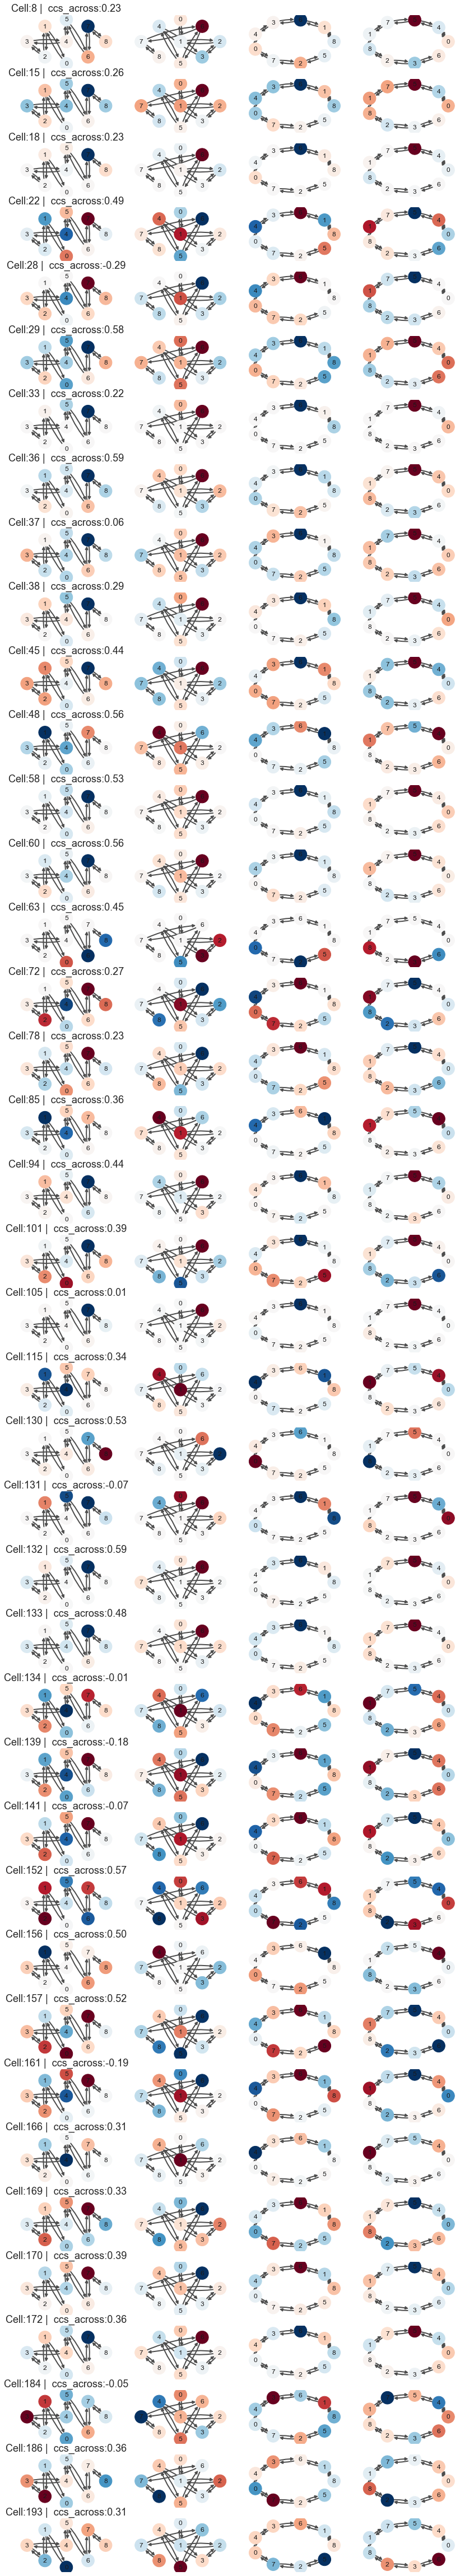

In [1296]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in range(len(ccs_within)):
    if ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i] - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i] - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],spks=spks,order='poke',mx=mx,mn=mn)
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],spks=spks,order='state',mx=mx,mn=mn)
        plt.subplot(n_plot,4,4*ctr+4)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

In [1329]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]


In [1330]:
resps_state_g1.shape

(228, 9)

In [1331]:
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
    #print(pred.shape,params.shape,x)
    #tmp = -np.corrcoef(pred,y)[0,1]
    #print(tmp)
    #if not np.isfinite(tmp):
    #    tmp = -10
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [1565]:
res_t1 = []
res_t2 = []
all_cc = []
all_shuffle_cc = []
t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 0
params_ranges = [slice(0,4,.25),slice(0,np.pi,np.pi/9)]
#params_ranges = [slice(0,4,.5),slice(0,np.pi,np.pi/9),slice(0,1,.25),slice(0,1,.25)]




for i in ixs:
    sys.stdout.write('\r running cell:{}'.format(i))
    sys.stdout.flush()
    
    y1 = resps_state_g1[i] #np.random.permutation(resps_state_g1[i])
    y2 = resps_state_g2[i] #np.random.permutation(resps_state_g2[i])
    spks = y1 - (y1 + y2)/2.
    y = spks
    #y -= np.mean(y)
    #y /=np.max(y)

    #res1 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res1 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]
    
    cc1_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res1_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])
        



    
    

    spks = y2 - (y1 + y2)/2.
    y = spks
    #y = np.random.permutation(spks)
    #y -= np.mean(y)
    #y /=np.max(y)


    #res2 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res2 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc2 = np.corrcoef(y,np.cos(res2[0]*t_ + res2[1]))[0,1]
    
    cc2_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res2_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc2_shuff.append(np.corrcoef(spks_shuff,np.cos(res2_shuff[0]*t_ + res2_shuff[1]))[0,1])

    all_cc.append([cc1,cc2])
    all_shuffle_cc.append([cc1_shuff,cc2_shuff])
    
    res_t1.append(res1)
    res_t2.append(res2)
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

 running cell:210

In [1566]:
import scipy.stats as stt

In [1567]:
p_vals = []
for cell_ix,cell in enumerate(all_cc):
    tmp = []
    for task_nr in range(2):
        p1 = stt.percentileofscore(all_shuffle_cc[cell_ix][task_nr],cell[task_nr])
        tmp.append(p1)
    p_vals.append(tmp)

In [1568]:
np.mean((np.array(p_vals)>95))

1.0

In [1569]:
np.mean((np.array(p_vals)>95))

1.0

In [1570]:
all_cc[0]

array([0.68569814, 0.80544917])

In [1571]:
stt.percentileofscore(all_shuffle_cc[0][0],all_cc[0][0])

100.0

In [1572]:
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

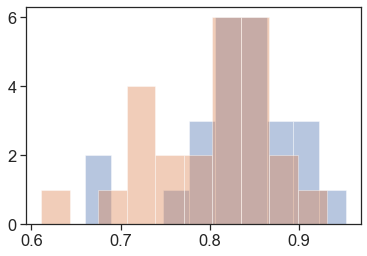

In [1573]:
seaborn.distplot(all_cc[:,0][np.isfinite(all_cc[:,0])],kde=0,bins=10)
seaborn.distplot(all_cc[:,1][np.isfinite(all_cc[:,0])],kde=0,bins=10)

In [1574]:
ixs = np.where(np.logical_and(all_cc[:,0]>0.6,all_cc[:,1]>0.6))[0]

In [1575]:
np.where(all_cc[:,0]>.6)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [1576]:
np.where(res_t1[:,0]>2.5) 

(array([16]),)

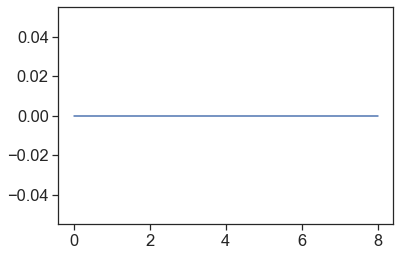

In [1577]:
plt.plot(resps_state_g1[0])

[1.        0.6981317]
[1.25      2.7925268]


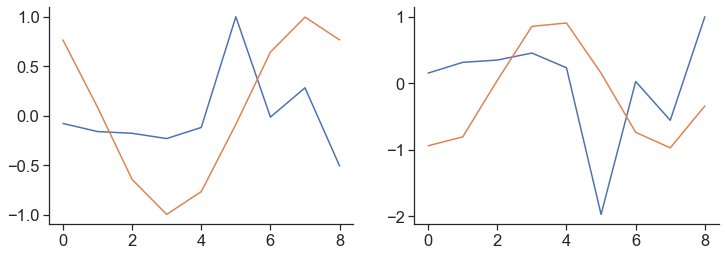

In [1578]:
plt.figure(figsize=(12,4))
ix = 4
plt.subplot(1,2,1)
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g1[ix]) - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)


pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)


plt.subplot(1,2,2)
x = res_t2[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix]) - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)

seaborn.despine()

[0.5        0.34906585]


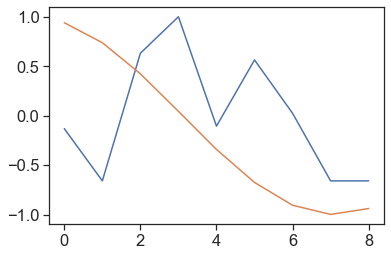

In [1579]:
ix = 8
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])
#y += np.min(y)
y -= np.mean(y)
y /=np.max(y)
pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)

In [1580]:
ix = 2
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])
#y += np.min(y)
y -= np.mean(y)
y /=np.max(y)
pred = np.cos(x[0]*t_ + x[1])*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [1581]:
ix = 94
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])
#y += np.min(y)
y -= np.mean(y)
y /=np.max(y)
pred = np.cos(x[0]*t_ + x[1])*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(y)
plt.plot(pred)

IndexError: index 94 is out of bounds for axis 0 with size 25

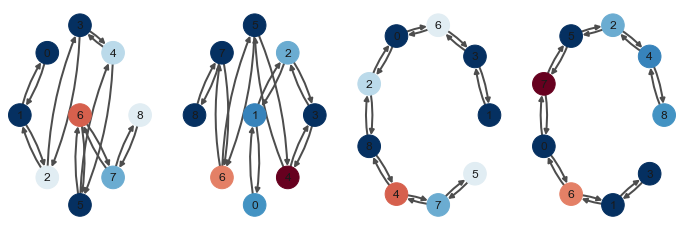

In [1582]:
plot_cell(94,all_resps1_g1,all_resps1_g2,all_poke_dict,norm=True,norm_pct=100)

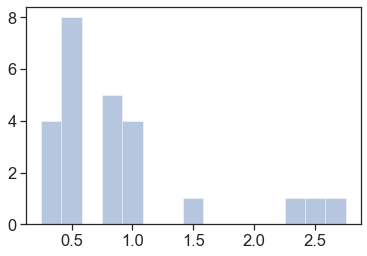

In [1583]:
seaborn.distplot(res_t1[:,0],kde=0,bins=15)

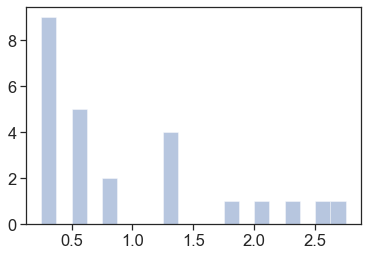

In [1584]:
seaborn.distplot(res_t2[:,0],kde=0,bins=20)

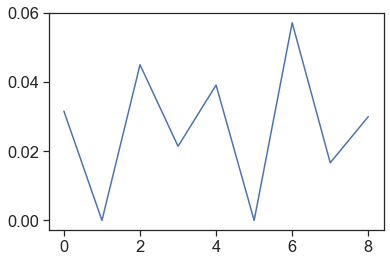

In [1585]:
plt.plot(resps_state_g1[ix])

In [1]:
thresh = 0.7
#ixs = np.where(np.logical_and.reduce([np.logical_or(all_cc[:,0]>thresh,
#                                                    all_cc[:,1]>thresh),
#                                     np.logical_or(ccs_within1>thresh,
#                                                   ccs_within2>thresh),
#                                     ]
#                                    ))[0]

#ixs = np.where(np.any(np.array(p_vals)>95,axis=1))[0]
seaborn.jointplot(res_t1[:,0]+np.random.normal(loc=0,scale=0.1,size=len(ixs)),
                  res_t2[:,0]+np.random.normal(loc=0,scale=0.1,size=len(ixs)),
                  kind='reg')
plt.plot([0,4.6],[0,4.6],color='.3',dashes=(7,7))
plt.xlim(0,4.6)
plt.ylim(0,4.6)

NameError: name 'seaborn' is not defined

In [1593]:
true_pop_cc = np.corrcoef(res_t1[ixs,0],res_t2[ixs,0])[0,1]
print(true_pop_cc)

0.843970682236354


In [1500]:
sys.path.append("/Users/yves/Documents/Code/")

In [1501]:
import yutils

In [1502]:
yutils.cc_pval(res_t1[ixs,0],res_t2[ixs,0])

(0.7129057548429938, 100.0)

In [1560]:
ixs

array([ 13,  38,  45,  55,  60,  67,  69,  85,  96, 100, 103, 104, 105,
       109, 115, 119, 121, 126, 141, 148, 153, 158, 180, 191, 210])

In [1598]:
all_shuff_pop_ccs = []
for iterN in range(100):
    print(iterN,)
    res_t1 = []
    res_t2 = []
    all_cc = []
    all_shuffle_cc = []
    t_ = np.linspace(0,2*np.pi,9)
    NSHUFF = 0
    params_ranges = [slice(0,4,.25),slice(0,np.pi,np.pi/9)]
    #params_ranges = [slice(0,4,.5),slice(0,np.pi,np.pi/9),slice(0,1,.25),slice(0,1,.25)]




    for cell_nr in ixs:
        sys.stdout.write('\r running cell:{}'.format(i))
        sys.stdout.flush()

        y1 = np.random.permutation(resps_state_g1[cell_nr])
        y2 = np.random.permutation(resps_state_g2[cell_nr])
        spks = y1 - (y1 + y2)/2.
        #y = spks
        #y -= np.mean(y)
        #y /=np.max(y)

        #res1 = op.minimize(fit_sin,
        #        [1,0],
        #        args=spks)
        res1 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
        cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]

        cc1_shuff = []
        for _ in range(NSHUFF):
            spks_shuff = np.random.permutation(spks)
            res1_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
            cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])







        spks = y2 - (y1 + y2)/2.
        #y = spks
        #y = np.random.permutation(spks)
        #y -= np.mean(y)
        #y /=np.max(y)


        #res2 = op.minimize(fit_sin,
        #        [1,0],
        #        args=spks)
        res2 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
        cc2 = np.corrcoef(y,np.cos(res2[0]*t_ + res2[1]))[0,1]

        cc2_shuff = []
        for _ in range(NSHUFF):
            spks_shuff = np.random.permutation(spks)
            res2_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
            cc2_shuff.append(np.corrcoef(spks_shuff,np.cos(res2_shuff[0]*t_ + res2_shuff[1]))[0,1])

        all_cc.append([cc1,cc2])
        all_shuffle_cc.append([cc1_shuff,cc2_shuff])

        res_t1.append(res1)
        res_t2.append(res2)
    
    
    all_cc = np.array(all_cc)
    res_t1 = np.array(res_t1)
    res_t2 = np.array(res_t2)
    cc_pop = np.corrcoef(res_t1[:,0],res_t2[:,0])[0,1]
    print('.  ',cc_pop)
    all_shuff_pop_ccs.append(cc_pop)

0
 running cell:210

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


 running cell:210.   0.7944308815559052
1
 running cell:210.   0.7436087439800118
2
 running cell:210.   0.8413959449537626
3
 running cell:210.   0.7402649886711419
4
 running cell:210.   0.6925114393997122
5
 running cell:210.   0.633480970794
6
 running cell:210.   0.7224568955895381
7
 running cell:210.   0.5265427606793831
8
 running cell:210.   0.6157793164812423
9
 running cell:210.   0.5244006147230673
10
 running cell:210.   0.8860178171714672
11
 running cell:210.   0.5637637760783536
12
 running cell:210.   0.5506146297961148
13
 running cell:210.   0.6889569738275112
14
 running cell:210.   0.8996578999159752
15
 running cell:210.   0.5841530245556902
16
 running cell:210.   0.6631790957729969
17
 running cell:210.   0.7001832234053191
18
 running cell:210

KeyboardInterrupt: 

In [1597]:
res_t1

[array([0., 0.]),
 array([3.5       , 1.04719755]),
 array([3.25      , 0.34906585]),
 array([0., 0.]),
 array([1.75     , 2.7925268])]

In [1562]:
ixs

array([ 13,  38,  45,  55,  60,  67,  69,  85,  96, 100, 103, 104, 105,
       109, 115, 119, 121, 126, 141, 148, 153, 158, 180, 191, 210])

In [1505]:
stt.percentileofscore(all_shuff_pop_ccs,true_pop_cc)

93.0